In [23]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import factorial
from scipy.linalg import inv as Inv
from scipy.linalg import eig
from scipy.sparse import diags
import time



# x, t  --> ksi, tau
def subtitution(x, t, R_func):
    ksi = x / R_func(t)
    tau = t
    return (ksi, tau)

def subtitutionXT(ksi, tau, R_func):
    t = tau
    x = ksi * R_func(t)
    return (x, t)


def polyFit(t0, dt, gamma): 
    rhs = np.array([1, 1 + gamma *dt , 0 , gamma], dtype=np.double)
    t1 = t0 - dt 
    t2 = t0 + dt
    matrix = np.array([[1, t1, t1**2, t1**3],
                        [1, t2, t2**2, t2**3],
                        [0, 1, 2 * t1, 3 * t1**2],
                        [0, 1, 2 * t2, 3 * t2**2]])
    res = np.linalg.solve(matrix, rhs)
    return res

def polynom(x, coefs):
    res = 0.0
    for idx, c in enumerate(coefs):
        res += c * (x**idx)
    return res

def matrixExponent(matr, isDiagonal=False, isTridiagonal=False):
    n = matr.shape[0]
    first_term = np.diag(np.ones(n)) + matr / 2
    second_term = np.diag(np.ones(n)) - matr / 2
    second_term = Inv(second_term)
    return first_term @ second_term

    
def R_function(t, coefs, gamma, t0, dt):
    if t <= t0 - dt:
        return 1.0
    elif t <= t0 + dt:
        return polynom(t, coefs)
    else:
        return gamma * t + 1 - gamma * t0
    
def R_deriv(t, coefs, gamma, t0, dt):
    if t <= t0 - dt:
        return 0.0
    elif t <= t0 + dt:
        return 3 * coefs[3] * t * t + 2 * coefs[2] * t + coefs[1]
    else:
        return gamma
        

def R_deriv_deriv(t, coefs, t0, dt):
    if t0 - dt <= t <= t0 + dt:
        return 6 * coefs[3] * t + 2 * coefs[2]
    else:
        return 0.0

def waveFunctionTheory(x, t, p_0):
    # ampl = 1.0 / np.sqrt(1 + 1j * t)
    ampl =  np.sqrt(np.sqrt( 1.0 / (2 * np.pi))) #  * 1.0 /( np.sqrt(1 + 1j * t) )
    expPart = np.exp( ( (2 * p_0 + 1j * x)**2 ) / ( 4 * (1 + 1j * t) )  - p_0**2)
    return ampl * expPart

def psi_analytical(x, t):
    ampl = 1 / np.sqrt(1 + 1j * t)  *  np.sqrt(np.sqrt(1 / (2 * np.pi)))
    exponent = np.exp(- x**2 / (4 * (1 + 1j * t)))
    return ampl * exponent

def psi_0(x, sigma, x0, p0) -> complex:
    ampl = 1.0 / (np.sqrt(sigma * np.sqrt(np.pi)))
    firstExp = np.exp( (-1) * ( (x - x0) / (np.sqrt(2) * sigma) )**2 )
    secondExp = np.exp(1j * p0 * x)
    return ampl * firstExp * secondExp

def squaredNorm(value):
    return abs(value)**2

def makeH_ksi_t(t, chis, n: int, R: np.double, coefs, gamma, t0, dt) -> np.ndarray:
    R_func = R_function(t, coefs, gamma, t0, dt)
    delta = 2*R / (n-1)
    H0_diagonal = np.zeros(n, dtype=np.double)
    H0_subDiagonal = np.ones(n-1, dtype=np.double) * (-1) / (delta * delta * R_func * R_func)
    
    xs = np.linspace(-R, R, n, dtype=np.double)
    for i in range(n):
        H0_diagonal[i] = 2 / (delta * delta * R_func * R_func) +  R_deriv_deriv(t, coefs, t0, dt) * R_func * chis[i] * chis[i]/ 4

    # return diags([diagonal, subDiagonal, subDiagonal], [0, -1, 1])
    return diags([H0_diagonal, H0_subDiagonal, H0_subDiagonal], [0, -1, 1]).toarray()  
    # return (H0_diagonal, H0_subDiagonal)

def psi_to_phi(psi, chis, t, coefs, gamma, t0, dt):
    first_term = np.sqrt(R_function(t, coefs, gamma, t0, dt))
    second_term = np.exp( (1j / 4) * R_deriv(t, coefs, gamma, t0, dt) * R_function(t, coefs, gamma, t0, dt) * chis**2 )
    return first_term * second_term * psi

def phi_to_psi(phi, chis, t, coefs, gamma, t0, dt):
    first_term = 1 / np.sqrt(R_function(t, coefs, gamma, t0, dt))
    second_term = np.exp( (-1j / 4) * R_deriv(t, coefs, gamma, t0, dt) * R_function(t, coefs, gamma, t0, dt) * chis**2 )
    return first_term * second_term * phi

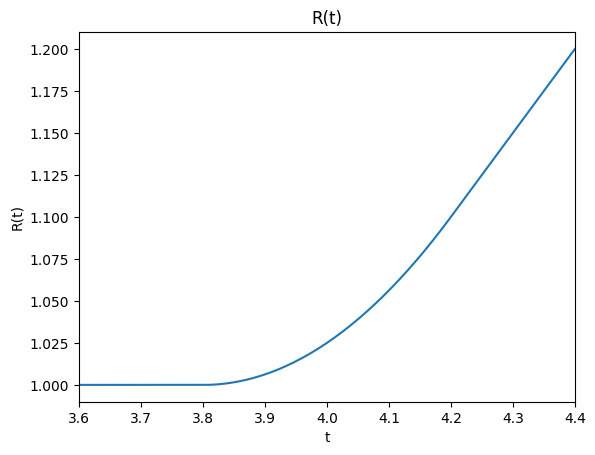

In [5]:
t0 = 4
dt = 0.2
gamma = 0.5
coefs = polyFit(t0, dt, gamma)
xs = np.linspace(0, 1.1*t0, 1000)
ys = np.zeros_like(xs)
for idx, x in enumerate(xs):
    ys[idx] = R_function(x, coefs, gamma, t0, dt)

plt.plot(xs, ys)
plt.xlim([t0 - 2 * dt, t0 + 2*dt])
plt.xlabel("t")
plt.ylabel("R(t)")
plt.title("R(t)")
plt.savefig(("R_t.png"), dpi=300, bbox_inches='tight')
plt.show()


0.0 0
1.0 1
2.0 2
3.0 3
4.0 4
5.0 5
6.0 6
7.0 7
8.0 8
9.0 9
10.0 10


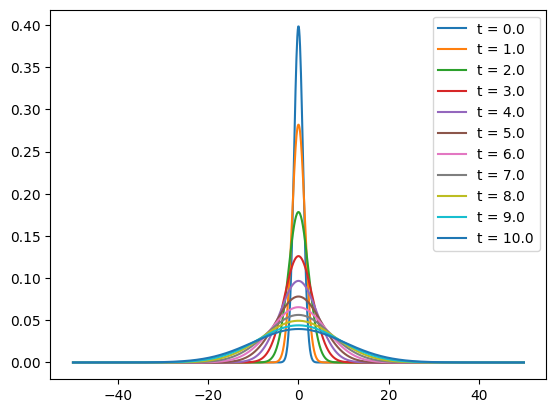

In [8]:
numberOfPoints = 1000
boxBorder = 50
x_0 = 0
p_0 = 0

xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
# ys = squaredNorm(psi_0(xs, sigma, x_0, p_0))


# plt.plot(xs, ys)
# plt.show()

ts = np.linspace(0, 10, 11)
for t, ind in zip(ts, range(len(ts))):
    print(t, end=" ")
    print(ind)
    psi_t = waveFunctionTheory(xs, t, p_0)
    
    plt.plot(xs, squaredNorm(psi_t), label=("t = {:2.1f}".format(t)))

plt.legend()
plt.show()

In [30]:
numberOfPoints = 1000
boxBorder = 10
x_0 = 0
p_0 = 0
t0 = 2
dt = 1
gamma = 5
filenames = []


coefs = polyFit(t0, dt, gamma)
t_lim = 20
n_ts = 100
ts = np.linspace(0, t_lim, n_ts)
t_step = t_lim / (n_ts - 1)

xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
chis = np.linspace(-boxBorder, boxBorder, numberOfPoints)
# chis, tau = subtitution(xs, 0, lambda x: R_function(x, coefs, gamma, t0, dt))
# psi = waveFunctionTheory(xs, t=0.0, p_0=p_0)# psi_0(xs, sigma, x_0, p_0) 
psi = psi_analytical(xs, t=0.0)

psi_t = psi
phi_t = psi_to_phi(psi_t, chis, 0, coefs, gamma, t0, dt)
for t, ind in zip(ts, range(len(ts))):
    # chis, tau = subtitution(xs, t, lambda x: R_function(x, coefs, gamma, t0, dt))
    xs, tau = subtitutionXT(chis, t, lambda x: R_function(x, coefs, gamma, t0, dt))
    
    psi_t = phi_to_psi(phi_t, chis, t, coefs, gamma, t0, dt)

    H_chi = makeH_ksi_t(t + t_step / 2, chis, numberOfPoints, boxBorder, coefs, gamma, t0, dt)
    
    evolution_step = matrixExponent((-1j) * t_step * H_chi)
    # print(evolution_step)
    y_theory_x = psi_analytical(xs, t)
    y_theory_xi = psi_to_phi(y_theory_x, chis, t, coefs, gamma, t0, dt)
    
    # H_t = matrixExponent((-1j) * t * H)
    # psi_t = H_t @ psi

    # print(Integrate(lambda x: coordinateTimeExponent(x, t), -boxBorder, boxBorder))
    # print(Integrate(lambda x: psi_0(x, sigma, x_0, p_0), -boxBorder, boxBorder))
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

    axes[0].plot(xs, squaredNorm(psi_t), label=("Module".format(t)))
    axes[0].plot(xs, squaredNorm(y_theory_x), 'r--', label="True solution")
    # axes[0].plot(xs, psi_t.real, label=("Real".format(t)))
    # axes[0].plot(xs, psi_t.imag, label=("Imag".format(t)))
    axes[0].set_title(("t = {:2.1f}".format(t)))
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Psi (X)")
    axes[0].set_ylim(-1, 1)
    axes[0].legend(loc='upper right')
    axes[1].plot(chis, squaredNorm(phi_t), label=("Module".format(t)))
    axes[1].plot(chis, squaredNorm(y_theory_xi), 'r--', label="True solution")
    # axes[1].plot(chis, y_theory, 'r--', label="True solution")
    # axes[1].plot(chis, phi_t.real , label=("Real".format(t)))
    # axes[1].plot(chis, phi_t.imag, label=("Imag".format(t)))
    axes[1].set_title(("t = {:2.1f}".format(t)))
    axes[1].set_xlabel("Xi")
    axes[1].set_ylabel("Phi (Xi)")
    axes[1].set_ylim(-1, 1.5)
    plt.legend(loc='upper right')
    

    
    phi_t = evolution_step @ phi_t
    # psi_t = evolution_step @ psi_t
    nof = ("imgs_evol_justModule/t_" + str(ind) + ".png")
    plt.savefig(nof, dpi=300, bbox_inches='tight')
    filenames.append(nof)
    plt.clf()


C:\Users\kiril\AppData\Local\Temp\ipykernel_6536\1476034464.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [31]:
import imageio
images = []
for filename in filenames:
    images.append(imageio.v2.imread(filename))
imageio.mimsave('EvolutionModule.gif', images)